# Analysing election data using Pandas

Before you start you need Pandas/Numpy.
The best way to do this is to install Anaconda.

[Download here](https://www.continuum.io/downloads)


In [1]:
import pandas as pd
import numpy as np


# Get the data

this is really easy with Pandas as you don't have to 
think about what file format you use. The source files are available
(free as in beer) on different sites official French sites
but finding them  takes a bit of googling as they aren't well referenced.
It's best to download so as  to have local copies.

The first file contains electoral districts by code but not the GPS data.
So we will have to add this from the second source:

- [Election results here](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-23-avril-et-7-mai-2017-resultats-du-1er-tour-1/) this is an **MS Excel file**

- [Postal codes/GPS are available here](https://www.data.gouv.fr/fr/datasets/base-officielle-des-codes-postaux/)
**comma separated values** file.

Both file formats are common and it is easy:
- to convert beteen them
- to transfer data from one to another.







# Gotchas

There are 2 parameters we have to set otherwise the data is [FUBAR](https://en.wikipedia.org/wiki/List_of_military_slang_terms#FUBAR):

1. Skip the first 3 lines in the .xls as they are BS **skiprows=3**
1. The separator for the csv file - which isn't a comma **sep= ';'**


The Excel file is about 40M so it will take a while to load and parse.

In [2]:
dd = pd.read_csv( '/Users/macbuse/Desktop/ELECTIONS FRANCE/correspondance-code-insee-code-postal.csv', sep= ';'  )

In [3]:
pp = pd.read_excel('/Users/macbuse/Desktop/ELECTIONS FRANCE/Presidentielle_2017_Resultats_Communes_Tour_1.xls',
                   skiprows=3)

# Dipping in

Both files are now in a common table format - [Pandas dataframe](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python). In examples we use **df** for the name of a generic dataframe.

The rows of the table are indexed like this:
- **df.loc[0]** is the first row but it isn't pretty

We can get a view of the first few lines just to see what the column names in the tables are.<br>

- **df[:5]**



In [147]:
dd.loc[0]

Code INSEE                                                         32460
Code Postal                                                        32720
Commune                                                       VERGOIGNAN
Département                                                         GERS
Région                                                     MIDI-PYRENEES
Statut                                                    Commune simple
Altitude Moyenne                                                     126
Superficie                                                          1056
Population                                                           0.3
geo_point_2d                              43.7235746425, -0.188266221507
geo_shape              {"type": "Polygon", "coordinates": [[[-0.19884...
ID Geofla                                                          34962
Code Commune                                                         460
Code Canton                                        

In [149]:
#this is easier on the eye
dd[:3]

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,32460,32720,VERGOIGNAN,GERS,MIDI-PYRENEES,Commune simple,126,1056,0.3,"43.7235746425, -0.188266221507","{""type"": ""Polygon"", ""coordinates"": [[[-0.19884...",34962,460,24,3,32,73
1,51141,51240,LA CHAUSSEE-SUR-MARNE,MARNE,CHAMPAGNE-ARDENNE,Commune simple,130,2240,0.7,"48.8433156105, 4.54286173009","{""type"": ""Polygon"", ""coordinates"": [[[4.504753...",18178,141,33,4,51,21
2,77130,77580,COULOMMES,SEINE-ET-MARNE,ILE-DE-FRANCE,Commune simple,136,371,0.4,"48.8919104938, 2.92942534432","{""type"": ""Polygon"", ""coordinates"": [[[2.940606...",31737,130,8,1,77,11


## Column data

Then we can access column data in **df**:

- using that name by copy paste like this **df[['name']]**
- or by  an index  like this **df[[1]]**

The notation [[.]] is kind of curious but elegant.


In [134]:
dd[['Commune']][:5]


,Commune
0,VERGOIGNAN
1,LA CHAUSSEE-SUR-MARNE
2,COULOMMES
3,SAINT-MYON
4,AUCHY-LES-HESDIN


# Extracting a subset of the data

- we aren't going to need all the data so we will select some columns by index.
- we will also rename some columns so that it matches with the GPS data





In [6]:
cols = [0,2]
cols.extend([20 + 7 *k for k in range(5)])

pp.rename(columns={u'Code du département': 'Code Département',
                    'Code de la commune' :'Code Commune'},
                    inplace=True)
results = pp[cols]
results.sort_values(by=['Code Département','Code Commune'], ascending=[True, True])[:5]

,Code Département,Code Commune,Nom,Nom.1,Nom.2,Nom.3,Nom.4
0,1,1,LE PEN,MACRON,FILLON,MÉLENCHON,DUPONT-AIGNAN
1,1,2,LE PEN,MACRON,FILLON,MÉLENCHON,HAMON
2,1,4,LE PEN,MÉLENCHON,MACRON,FILLON,DUPONT-AIGNAN
3,1,5,LE PEN,FILLON,MACRON,MÉLENCHON,DUPONT-AIGNAN
4,1,6,MÉLENCHON,LE PEN,MACRON,FILLON,DUPONT-AIGNAN


and the GPS data looks like this

In [9]:
gps = dd[['Code Département', 'Code Commune','geo_point_2d']]
gps.sort_values(by=['Code Département', 'Code Commune'], ascending=[True, True])[:3]

,Code Département,Code Commune,geo_point_2d
28626,01,1,"46.1534255214, 4.92611354223"
34845,01,2,"46.0091878776, 5.42801696363"
22048,01,4,"45.9608475114, 5.3729257777"


# Getting longitude and latitude

The **geo_point_2d** data is a string so we have to split this
and convert the result to floatting point.
Actually we make a list 
- with entries( hash , [longitude, latitude]) 
- the hash is  **'Code Département' + 'Code Commune'** 


In [10]:
gps2 = [ (str(x['Code Département']) +  str(x['Code Commune']), 
                                     [ float(t) for t in x['geo_point_2d'].split(',')] ) for ix, x in gps.iterrows() ]

...now we have to create a lookup table for the coordinates. <br>
This is a Python dictionnary







In [11]:
gps2 = dict(gps2)

# Making new columns for the dataframe

## First we have to prepare the data

Now we have to make lists which contain the 
column data for longitudes and latitudes.

If there is no entry corresponding to the hash
then set the entry to **nan = not a number**


In [150]:

gps_col = []
for ix,x in results.iterrows():
    dc = str(x['Code Département'])
    #add a preceding 0 if single digit
    if len(dc) < 2:
        dc = '0' + dc
        
    kk =  dc +  str(x['Code Commune']) 
    #hash not found
    if kk not in gps2:
        gps_col.append([float('nan')]*2)
        continue
    gps_col.append(gps2[kk])

#can't use long as a variable name it is a reserved word
lng,lat = zip(*gps_col)

## Adding columns
adding the columns is simple 

In [15]:
results.loc[:,'long'] = pd.Series(lng, index=results.index)
results.loc[:,'lat'] = pd.Series(lat, index=results.index)

and lets look at things to see they are OK

In [16]:
results[:3]

,Code Département,Code Commune,Nom,Nom.1,Nom.2,Nom.3,Nom.4,long,lat
0,1,1,LE PEN,MACRON,FILLON,MÉLENCHON,DUPONT-AIGNAN,46.153426,4.926114
1,1,2,LE PEN,MACRON,FILLON,MÉLENCHON,HAMON,46.009188,5.428017
2,1,4,LE PEN,MÉLENCHON,MACRON,FILLON,DUPONT-AIGNAN,45.960848,5.372926


# Extraction and plotting 

Now we can extract data for plotting by asking the 
dataframe nicely for those  circonsriptions where 
a particular candidate **X** won like this :

results.loc[(results['Nom'] == **X** )  & (results['long'] != nan)]



In [17]:
nan = float('nan')
ham = results.loc[(results['Nom'] == u'HAMON')  & (results['long'] != nan)]
fil = results.loc[(results['Nom'] == u'FILLON')  & (results['long'] != nan)]
mel = results.loc[(results['Nom'] == u'MÉLENCHON')  & (results['long'] != nan)]

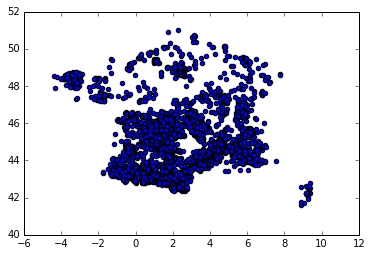

In [18]:
import matplotlib.pylab as plt

%matplotlib inline
# and drop na rows if any of the columns are NA
mydata = mel[["lat", "long"]].dropna(how="any")
# Now plot with matplotlib
vals = mydata.values
plt.scatter(vals[:, 0], vals[:, 1])

plt.axes().set_aspect('equal', 'datalim')


# Geometric data 

There is actually a geometric representation of 
each circonscription that is easy to plot. 

First lets look at the raw data.

In [88]:
dd['geo_shape'][0]

'{"type": "Polygon", "coordinates": [[[-0.198840174520842, 43.70794322452202], [-0.222235915236875, 43.71887029533192], [-0.19414330237234, 43.737016685694684], [-0.180792917516703, 43.73392241336569], [-0.166464609500636, 43.74073425722042], [-0.158609760122906, 43.733001456816694], [-0.165604514951094, 43.72182035935971], [-0.17757883861499, 43.71205146251945], [-0.198840174520842, 43.70794322452202]]]}'

## Format and extraction

This looks like [json](https://fr.wikipedia.org/wiki/JavaScript_Object_Notation)
which we should really parse 
but we'll use a quick hack to extract the data and  store it to a variable
referencing a [Python dictionary](https://en.wikibooks.org/wiki/Python_Programming/Dictionaries)
using **exec**.

In [89]:
exec('mpoly=' + dd['geo_shape'][1])
lon, lat = zip(*mpoly['coordinates'][0])

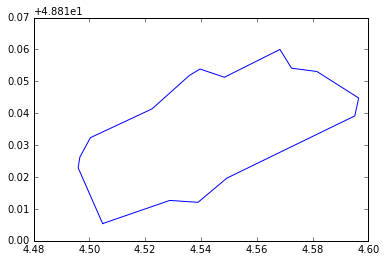

In [90]:
plt.plot(lon,lat)

## Central  Paris

Just to reassure ourselves let's look at Paris.
Using the department number = 75
we can pull all the districts in central Paris 
then draw just the boundaries using a simple comand.
To draw colored regions is a bit more complicated as we'll see below.

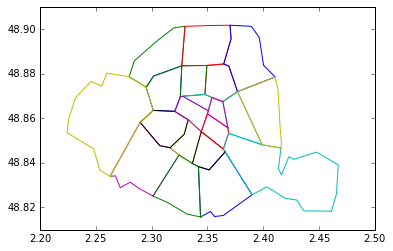

In [92]:
vv  = dd.loc[(dd['Code Département'] == '75')]
for x in vv['geo_shape'][:]:
    #create a reference to a dictionnary
    exec('mm=' + x)
    #extract longitude and latitudes as  2 lists
    lng, lat = zip(*mm['coordinates'][0])
    plt.plot(lng,lat)


# Geometric analysis of electoral districts
It should be possible to look for possible
**gerrymandering** using this.

*In the process of setting electoral districts, gerrymandering is a practice intended to establish a political advantage for a particular party or group by manipulating district boundaries. The resulting district is known as a gerrymander; however, that word can also refer to the process. The term gerrymandering has negative connotations. Two principal tactics are used in gerrymandering: "cracking" (i.e. diluting the voting power of the opposing party's supporters across many districts) and "packing" (concentrating the opposing party's voting power in one district to reduce their voting power in other districts).*

[Source:wiki](https://en.wikipedia.org/wiki/Gerrymandering)

## Geometry of gerrymandering

According to some theories if electoral districts are not roughly
like regular polygons then there is a high probablility that the
form has been chosen to favorise a certain electoral outcome.
There are projects in the US that are working on gerrymandering and geometry
for example:  [Metric geometry](https://sites.tufts.edu/gerrymandr/resources/)

*This site is devoted to the Metric Geometry and Gerrymandering Group run by Moon Duchin on understanding apportionment, districting, and gerrymandering as problems at the intersection of law, civil rights, and mathematics (particularly metric geometry).  Here is a partial reading list with a focus on shapes of U.S. Congressional Districts.*

[source](https://sites.tufts.edu/gerrymandr/resources/)


## An interesting indice

One way of measuring if a shape is not  like regular polygons this is 
the **isoperimetric quotient**
which we will calculate below.

Of course there are other [indices to look at](https://www.researchgate.net/profile/Chao_Fan4/publication/280499974_A_Spatiotemporal_Compactness_Pattern_Analysis_of_Congressional_Districts_to_Assess_Partisan_Gerrymandering_A_Case_Study_with_California_and_North_Carolina/links/5605805d08ae5e8e3f3289ca.pdf).







# Calculate isoperimetric quotient for a shape


For a given closed curve, the isoperimetric quotient is defined as the ratio of its area and that of the circle having the same perimeter. This is equal to

$$ Q= \frac{4 \pi A}{L^2}$$

the isoperimetric inequality says that $Q \leq 1$ and if Q = 1$ then the curve is a circle.

You can read more about this on the [wikipedia](https://en.wikipedia.org/wiki/Isoperimetric_inequality).
Actually the problem of getting the best  shape (that maximises the 
isoperimetric quotient) 
[according to legend](https://mathematicalgarden.wordpress.com/2008/12/21/the-problem-of-dido/) has it's origins in a political problem
of division of land.

## Python code

We have to define a couple of functions 
- **poly_area(M)** to calculate the area 
- **poly_perimeter(M)**  to calculate the perimeter

of a curve. These are one line functions 
which appear a bit cryptic because of the way  **Numpy** 
works.



In [117]:
#shoelace formula for area
#http://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates

def poly_area(M):
    x, y = M.transpose()
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def poly_perimeter(M):
    return sum ( np.linalg.norm(x) for x in (np.roll(M,1, axis=0) - M ) )
    


# Test on one example

so let's test it on some random shape from the electoral districts

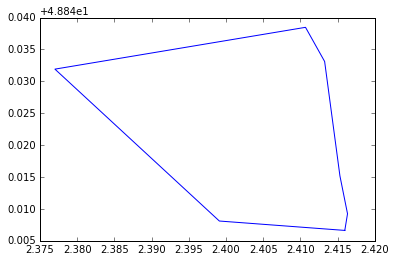

In [120]:
lon, lat = zip(*mm['coordinates'][0])
plt.plot(lon,lat)

In [121]:
DD = np.array(mm['coordinates'][0])
4*np.pi*poly_area(DD)/ poly_perimeter(DD)**2

0.71449319962608193

# Test on the regular n-gons

and test again to see if it behaves as we expect.

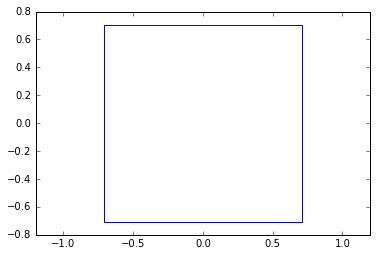

In [87]:
def reg_poly(N):
    T =  np.linspace(0 ,2*np.pi ,N+1) + np.pi/4
    DD = np.ones((2,N+1))
    DD[0,:] = np.cos(T)
    DD[1,:] = np.sin(T)
    return DD

#here is a square
DD = reg_poly(4)
plt.plot(DD[0,:],DD[1,:] )
plt.axes().set_aspect('equal', 'datalim')

# Calculation of isoperimetric quotient for polygons

In [78]:
for N in range(3,20):
    DD = reg_poly(N)
    area, peri = PolyArea(DD.transpose()), perimeter(DD.transpose())
    print '%d-gon isoperimetric quotient = %f'%(N, 4*np.pi*area/peri**2)

3-gon isoperimetric quotient = 0.604600
4-gon isoperimetric quotient = 0.785398
5-gon isoperimetric quotient = 0.864806
6-gon isoperimetric quotient = 0.906900
7-gon isoperimetric quotient = 0.931941
8-gon isoperimetric quotient = 0.948059
9-gon isoperimetric quotient = 0.959051
10-gon isoperimetric quotient = 0.966883
11-gon isoperimetric quotient = 0.972662
12-gon isoperimetric quotient = 0.977049
13-gon isoperimetric quotient = 0.980457
14-gon isoperimetric quotient = 0.983158
15-gon isoperimetric quotient = 0.985335
16-gon isoperimetric quotient = 0.987116
17-gon isoperimetric quotient = 0.988590
18-gon isoperimetric quotient = 0.989825
19-gon isoperimetric quotient = 0.990870


as you can see the isoperimetric quotient is
**monotone** increasing and always $\leq 1$.

Even for an equilateral triangle it is quite big $> 0.6$.


# Calculating for real electoral districts

So now we can take districts  department by department and see what 
the **isoperimetric quotient** gives.

The data is a bit dirty and so our (simple) function
won't  always work but it's a start...

In [124]:
def isoperimetric_quotient(dept):
    vv  = dd.loc[(dd['Code Département'] == dept)]
    communes = []
    for ix,ff in vv.iterrows():
        x = ff['geo_shape']
        exec('mm=' + x)
        DD = np.array( mm['coordinates'][0])
        communes.append( ( 4*np.pi*poly_area(DD) / poly_perimeter(DD)**2, ff['Commune'] , mm) )
    return communes


We'll test it on the  departement of the Seine <https://fr.wikipedia.org/wiki/Seine_(d%C3%A9partement)>

In [125]:
communes = isoperimetric_quotient('75')
communes.sort()
#best and worst communes
communes[-1], communes[0]

((0.7772025439461937,
  'PARIS-10E-ARRONDISSEMENT',
  {'coordinates': [[[2.363856758564782, 48.86743436510144],
     [2.354114163249875, 48.86927979700135],
     [2.347826239446091, 48.870630685567946],
     [2.349545307310846, 48.88362643315055],
     [2.364673564731968, 48.884292229428034],
     [2.36929440059686, 48.88332740002614],
     [2.377012647123743, 48.87191931652078],
     [2.363856758564782, 48.86743436510144]]],
   'type': 'Polygon'}),
 (0.36577393817755049,
  'PARIS-2E-ARRONDISSEMENT',
  {'coordinates': [[[2.350834505477619, 48.863344374598334],
     [2.327877416924118, 48.869863809746434],
     [2.347826239446091, 48.870630685567946],
     [2.354114163249875, 48.86927979700135],
     [2.350834505477619, 48.863344374598334]]],
   'type': 'Polygon'}))

## Representing all this graphically

We'll define a function to do this  which will read the
data we just stored in  **communes** and make a map
by drawing the polygon and coloring them according 
to the **isoperimetric quotient**. 

The color is calculated by another function **iso_quot2color**
which you can modify if you like.

In [151]:
from matplotlib.patches import Polygon

def iso_quot2color(x):
    '''helper function to convert to color
     - lighter is worse'''
    tmp = (1./x - 1)/2.
    if tmp > 1: tmp = 1.
    return (tmp, tmp, 0)

def show_isoperimetric_data(communes):
    fig, ax = plt.subplots()

    #we have to calculate the bounding box ourselves
    left, right = 100, 0 
    top, bottom = 0,100

    for score, name, shape in communes[:]:

        coords = np.array( shape['coordinates'][0])
        #more convenient to work with 
        #a list of x-coords and a list of y-coords
        xs,ys = coords.transpose()
        
        #update bounding box
        left = min(left,min(xs))
        right = max(right,max(xs))
        bottom = min(bottom ,min(ys))
        top = max(top,max(ys))

        polygon = Polygon( coords, True)
        polygon.set_facecolor( iso_quot2color(score) )
        ax.add_patch(polygon)
 
    #set up  bounding box 
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    #finally make sure that the aspect ratio is 1:1
    ax.set_aspect('equal', 'datalim')


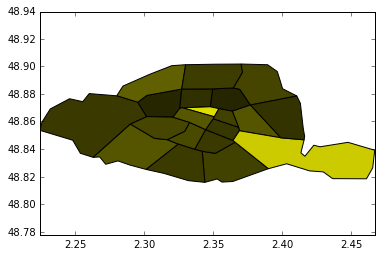

In [152]:
show_isoperimetric_data(isoperimetric_quotient('75'))


voila for the 93 

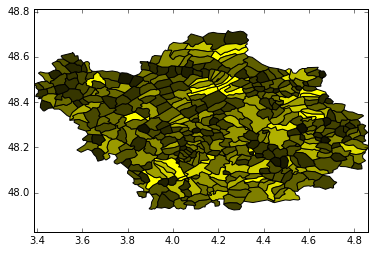

In [416]:
show_isoperimetric_data(isoperimetric_quotient('10'))

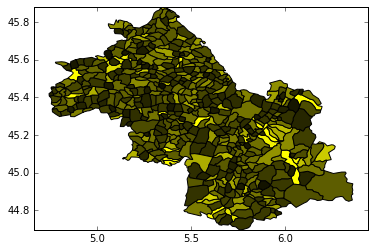

In [335]:
show_isoperimetric_data(isoperimetric_coeff('38'))

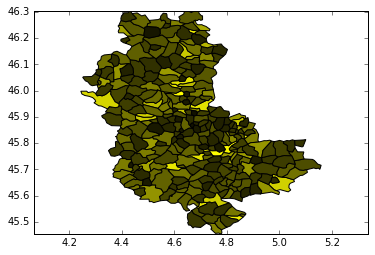

In [336]:
show_isoperimetric_data(isoperimetric_coeff('69'))

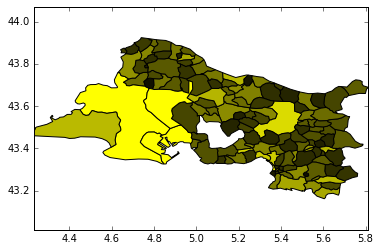

In [339]:
show_isoperimetric_data(isoperimetric_coeff('13'))

# Gotcha

Of course there are geographical reasons why the quotient is **bad**.

Take the case of 
[FOS-SUR-MER](https://www.google.fr/maps/place/Fos-sur-Mer/data=!4m2!3m1!1s0x12b619721d5cf72d:0xea40197d819691d?sa=X&ved=0ahUKEwjR0Z227MLTAhUJOBoKHduNBg4Q8gEIiwEwDA)
which is part of Marseille.


In [112]:
L = isoperimetric_quotient('13')
L.sort()
L[0][1]

'FOS-SUR-MER'

This is the worst case  in Marseille.
And here is the boundary

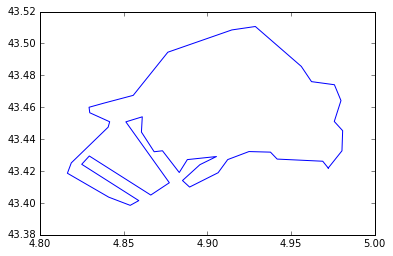

In [115]:

lon, lat = zip(*L[0][2]['coordinates'][0])
plt.plot(lon,lat)

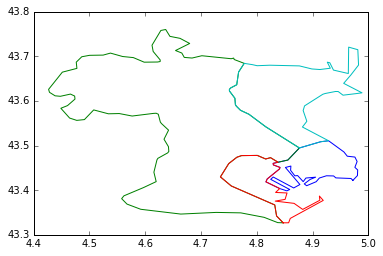

In [114]:
for x in L[0:4]:
    lon, lat = zip(*x[2]['coordinates'][0])
    plt.plot(lon,lat)


Of course, part  of the boundary goes round the Port in Marseille so the perimeter is relatively long.